# Lab 1 : Working with Optimizers and Convolutional Neural Networks

---

Total Points: **60**

Tentative Weightage : **10%**

Submission Deadline : **11th September 2020, 23:59 hours**

---
**General Instructions:**

---
1. You have to do this lab individually
2. You may use either Tensorflow 2.x or PyTorch framework
3. Please start **early** as the experiments may take time to run
4. All the code should be submitted in the form of a single Jupyter notebook itself.
5. Points for each sub-section are mentioned in the appropriate question.
6. You can use Google colab to run a jupyter notebook (https://colab.research.google.com/) How to load data in Google Colab ?(https://towardsdatascience.com/3-ways-to-load-csv-files-into-colab-7c14fcbdcb92) (https://www.marktechpost.com/2019/06/07/how-to-connect-google-colab-with-google-drive/)
7. The lab must be submitted on **Google classroom**. The code as well as the accompanying observations should be made part of the python notebook.
8. **Code Readability** is very important. Modularize your code by making use of classes, functions that can be flexibly reused wherever necessary. Also use self explanatory variable names and add comments to describe your approach wherever necessary. You may add additional code or text blocks as necessary. 
9.You are expected to submit your **detailed inferences** (preferably in a text block) and not just an error free code.
10. Students are expected to follow the **honor code** of the class.

In [1]:
# Import the necessary libraries 
import tensorflow as tf
import matplotlib.pyplot as plt
from matplotlib import cm
import numpy as np
import tensorflow.keras.optimizers as optimizers
import random
import os
import cv2

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


# Optimizers(Total for this subsection : **30 points**)
---
The aim of this section is to understand the loss surface of the neural network and study the behaviour of various optimization algorithms on it.

## To do

---
1. Study and implement: 
  *   Mini-batch gradient descent       **{2 points}**
  *   RMSProp [1]                       **{2 points}**
  *   Nesterov Accelerated Gradient [2] **{2 points}**
  *   ADAM [4]                          **{2 points}**

 on a two dimensional fuction like $f(w_1,w_2)=a_1(w_1-b_1)^2 +a_2(w_2-b_2)^2+c$ where $a_1,a_2,b_1,b_2$ and $c$ are hyperparameters which affect the rate of convergence of these algorithms.
2. Experiment these optimization techniques on the non-convex function(s)  (functions having saddle points and local minima's) to illustrate the effectiveness of each of these techniques. **{3 points}**
3. Show the optimization progress on mesh and contour plots. **{2+2=4 points}**
4. Are there any limitations of these algorithms (specifically ADAM)? **{3 points}**
5. What could be the characteristics of a better optimizer to overcome the limitations in Q4 ? **{2 points}**
6. Design your own optimizer and compare it with ADAM. **{6+4=10 points}**

---
**Note 1:** It is alright if your optimizer cannot overperform state of the art optimizer ADAM. But you are expected to have a clear insight of each component of your proposed optimizer.

**Note 2:** Clearly cite the refrenced material.
<!-- But you will have to do a comparative analysis of the proposed optimizer and ADAM. -->

---
References:
1. Tieleman, Tijmen and Hinton, Geoffrey (2012). Lecture 6.5-rmsprop: Divide
the gradient by a running average of its recent magnitude. COURSERA:
Neural Networks for Machine Learning.
2. Nesterov, Y. (1983). A method for unconstrained convex minimization
problem with the rate of convergence o(1/k2). Doklady ANSSSR (translated
as Soviet.Math.Docl.), vol. 269, pp. 543– 547
2121–2159.
3. Kingma, D. P., & Ba, J. L. (2015). Adam: a Method for Stochastic
Optimization. International Conference on Learning Representations, 1–13



##Plotting utility functions


In [53]:
def plot_mesh_and_contour(objective_function, w1_path, w2_path, extra_limit = 5, levels =10):
  """
    objective_function: function which describes the loss surface
    w1_path: list of values of w1_path obtained during the oprimization process
    w2_path: list of values of w2_path obtained during the oprimization process
  """
  w1_path = np.array(w1_path)
  w2_path = np.array(w2_path)
  
  fig = plt.figure(figsize=(30, 12))
  

  min_limit = min(np.min(w1_path)-extra_limit, np.min(w2_path)-extra_limit) 
  max_limit = max(np.max(w1_path)+extra_limit, np.max(w2_path)+extra_limit) 


  X = np.arange(min_limit, max_limit, 0.25)
  Y = np.arange(min_limit, max_limit, 0.25)
  X, Y = np.meshgrid(X, Y)
  Z = objective_function(X, Y)
  #plot the first subplot i.e 3d mesh
  ax = fig.add_subplot(1, 2, 1, projection='3d')
  ax.view_init(75, 30)
  surf = ax.plot_surface(X, Y, Z, cmap=cm.coolwarm, linewidth=0, antialiased=False, alpha=0.2)
  ax.set_title('3D Mesh Plot of Objective Function Surface')
  fig.colorbar(surf, shrink=0.5, aspect=5)
  #plot the lines on the 3d mesh
  for step_num in range(1, w1_path.shape[0]):
    ax.plot([w1_path[step_num-1], w1_path[step_num]], [w2_path[step_num-1], w2_path[step_num]], [objective_function(w1_path[step_num-1],w2_path[step_num-1] ), objective_function(w1_path[step_num],w2_path[step_num])] , marker='x')
  #plot the contours
  ax = fig.add_subplot(1, 2, 2)
  ax.set_title('Contour Plot of Objective Function Surface')
  surf = ax.contourf(X, Y, Z, levels, cmap=cm.coolwarm, alpha=0.5)
  fig.colorbar(surf, shrink=0.5, aspect=5)
  #plot the lines on the contour plot

  x_path = np.array(w1_path, dtype=float)
  y_path = np.array(w2_path, dtype=float)
  # ax.quiver(x_path[:-1], y_path[:-1], x_path[1:]-x_path[:-1], y_path[1:]-y_path[:-1], scale_units='xy', angles='xy', scale=1, color='k')
  for step_num in range(1, w1_path.shape[0]):
    ax.plot([w1_path[step_num-1], w1_path[step_num]], [w2_path[step_num-1], w2_path[step_num]], marker='x')


#Optimizer Demonstration for Convex Functions

*   SGD
*   RMS Prop
*   Nesterov Momentum
*   Adam



##Hyperparameters for the convex function

In [34]:
a1=1.0
a2=1.0
b1=0.0
b2=0.0
c=0.0

##Plot the convex function surface

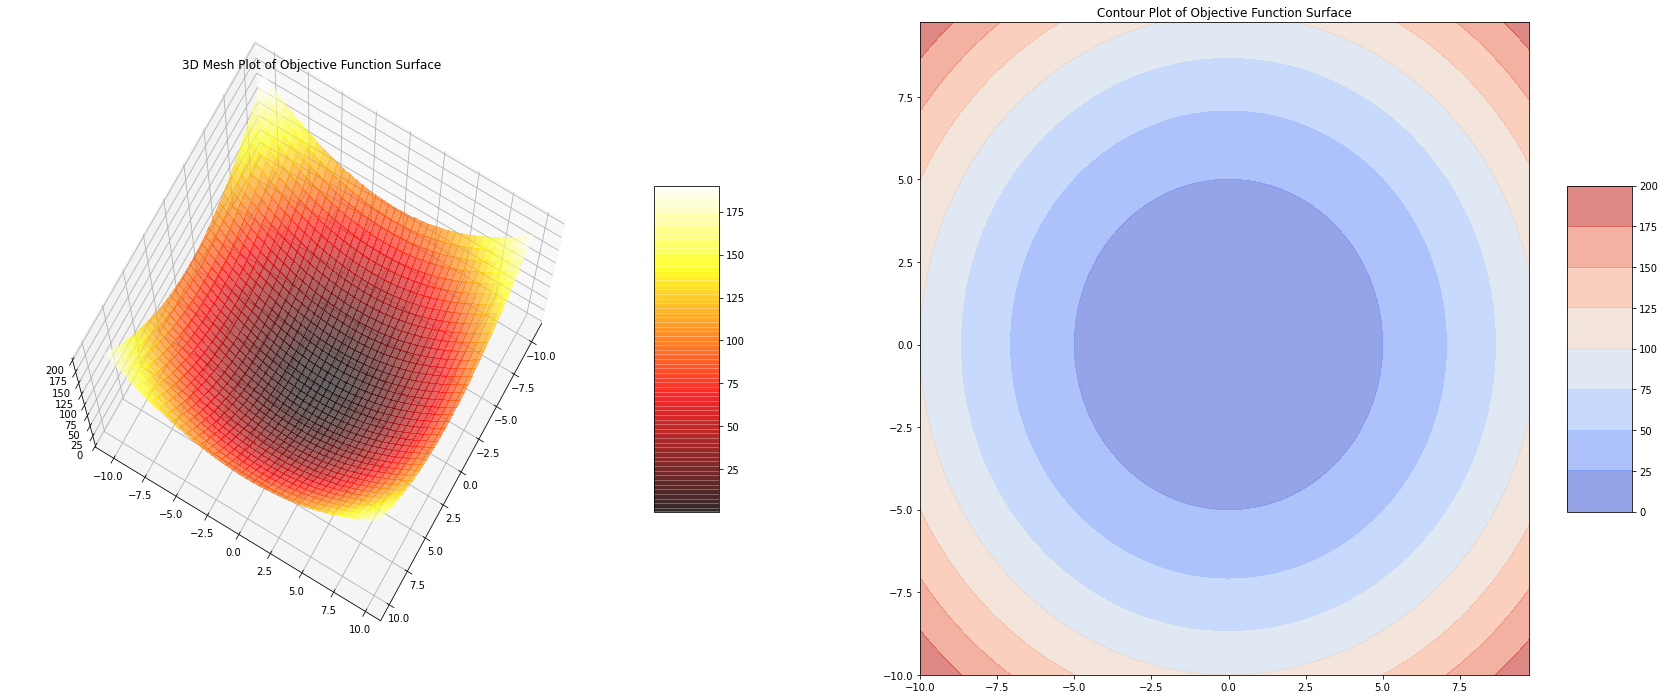

In [35]:
def get_objective_value_convex(w1_samples, w2_samples):
  return a1*((w1_samples-b1)**2) + a2*((w2_samples-b2)**2) + c

fig = plt.figure(figsize=(30, 12))
ax = fig.add_subplot(1, 2, 1, projection='3d')
# ax = fig.gca(projection='3d')

# Make data.
X = np.arange(-10, 10, 0.25)
Y = np.arange(-10, 10, 0.25)
X, Y = np.meshgrid(X, Y)
Z = get_objective_value_convex(X, Y)

# Plot the surface.
ax.view_init(75, 30)
surf = ax.plot_surface(X, Y, Z, cmap=cm.hot, linewidth=0, antialiased=False, alpha=0.6)
ax.set_title('3D Mesh Plot of Objective Function Surface')


# Add a color bar which maps values to colors.
fig.colorbar(surf, shrink=0.5, aspect=5)

ax = fig.add_subplot(1, 2, 2)
ax.set_title('Contour Plot of Objective Function Surface')
surf = ax.contourf(X, Y, Z, cmap=cm.coolwarm, alpha=0.6)
fig.colorbar(surf, shrink=0.5, aspect=5)


##SGD


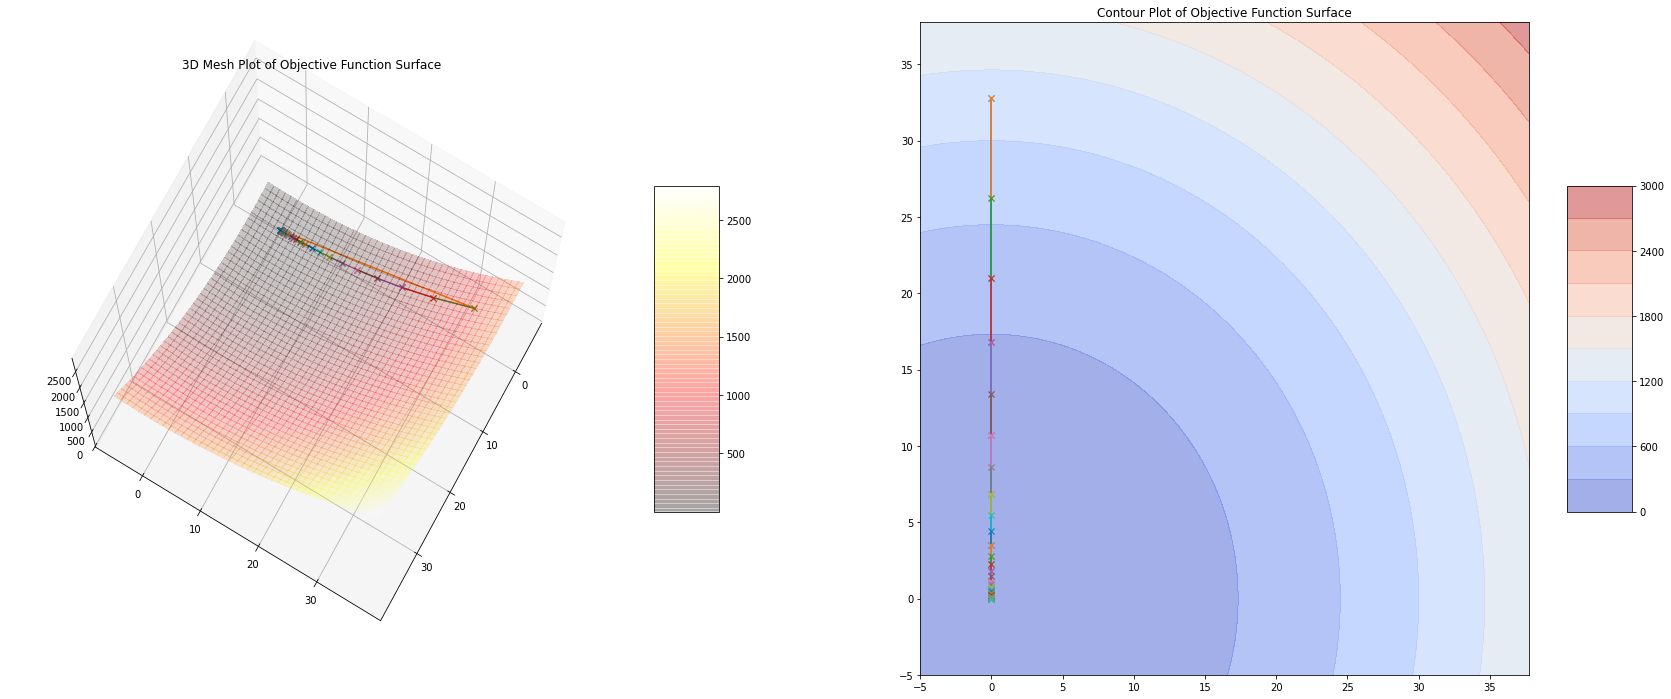

In [6]:
w1 = tf.Variable(float(random.randint(-50, 50)))
w2 = tf.Variable(float(random.randint(-50, 50)))


epochs = 100
optim = optimizers.SGD(1e-1)

w1_path = [w1]
w2_path = [w2]

#run the epochs
for epoch in range(epochs):
  with tf.GradientTape() as g:
    g.watch([w1, w2])
    f = a1*((w1-b1)**2) + a2*((w2-b2)**2) + c
    df_dw = g.gradient(f, [w1, w2])
    optim.apply_gradients(zip(df_dw, [w1, w2]))
    w1_path.append(w1.numpy())
    w2_path.append(w2.numpy())

#plot the mesh and contour graphs with the steps
plot_mesh_and_contour(get_objective_value_convex, w1_path, w2_path)

##RMS Prop


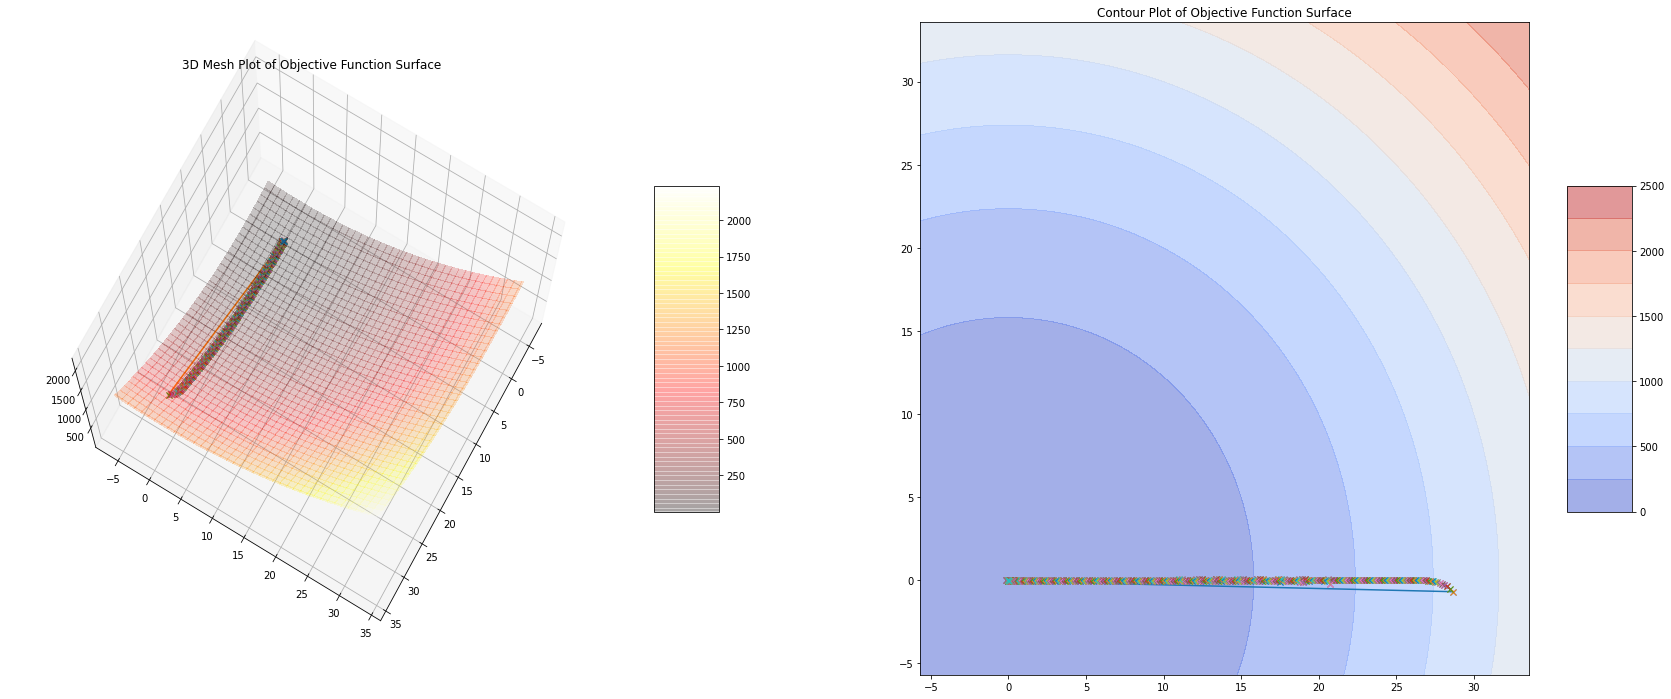

In [7]:
w1 = tf.Variable(float(random.randint(-50, 50)))
w2 = tf.Variable(float(random.randint(-50, 50)))


epochs = 500
optim = optimizers.RMSprop(1e-1)

w1_path = [w1]
w2_path = [w2]

#run the epochs
for epoch in range(epochs):
  with tf.GradientTape() as g:
    g.watch([w1, w2])
    f = a1*((w1-b1)**2) + a2*((w2-b2)**2) + c
    df_dw = g.gradient(f, [w1, w2])
    optim.apply_gradients(zip(df_dw, [w1, w2]))
    w1_path.append(w1.numpy())
    w2_path.append(w2.numpy())

#plot the mesh and contour graphs with the steps
plot_mesh_and_contour(get_objective_value_convex, w1_path, w2_path)

##Nesterov

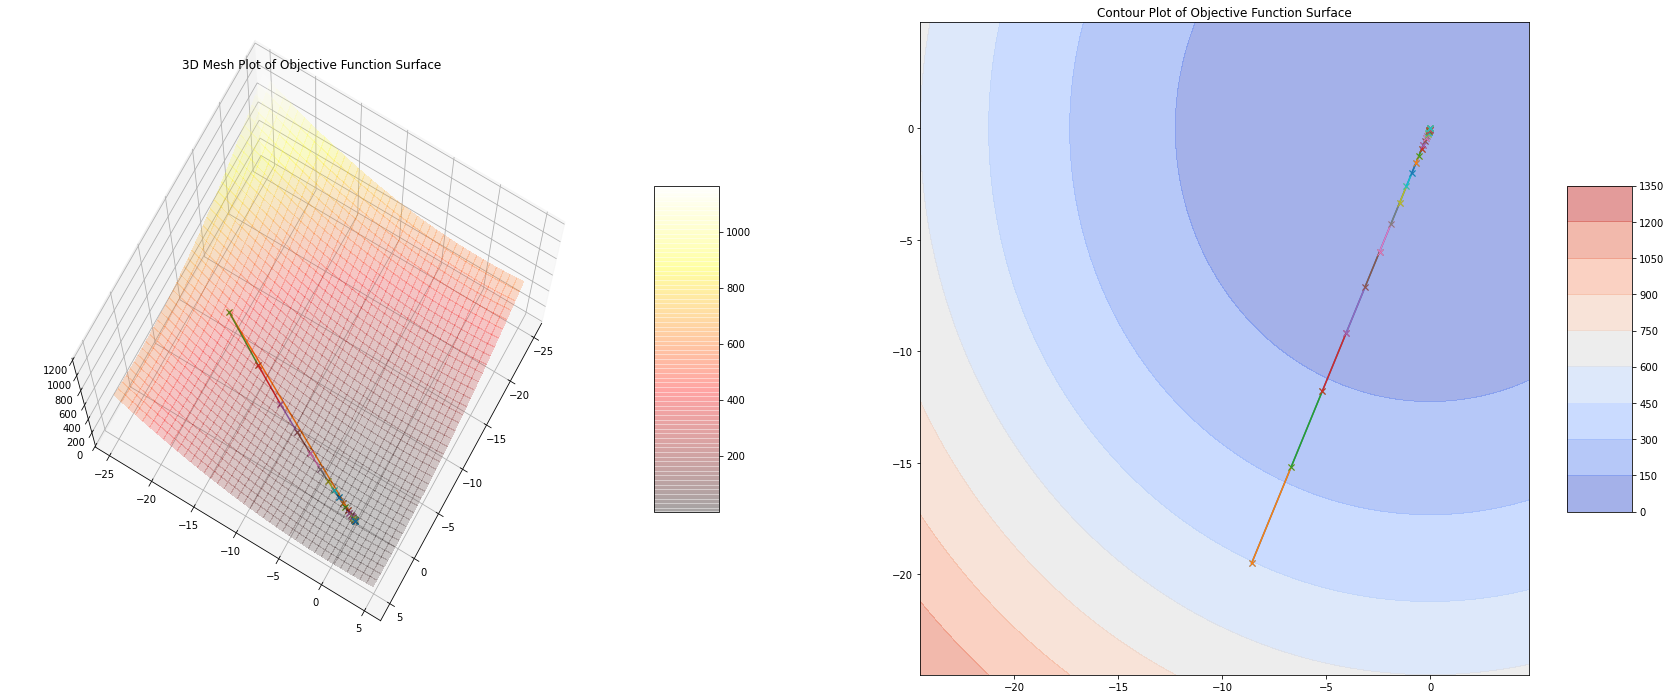

In [8]:
w1 = tf.Variable(float(random.randint(-50, 50)))
w2 = tf.Variable(float(random.randint(-50, 50)))


epochs = 100
optim = optimizers.SGD(1e-1, momentum=0.1,   nesterov=True)

w1_path = [w1]
w2_path = [w2]

#run the epochs
for epoch in range(epochs):
  with tf.GradientTape() as g:
    g.watch([w1, w2])
    f = a1*((w1-b1)**2) + a2*((w2-b2)**2) + c
    df_dw = g.gradient(f, [w1, w2])
    optim.apply_gradients(zip(df_dw, [w1, w2]))
    w1_path.append(w1.numpy())
    w2_path.append(w2.numpy())

#plot the mesh and contour graphs with the steps
plot_mesh_and_contour(get_objective_value_convex, w1_path, w2_path)

##Adam


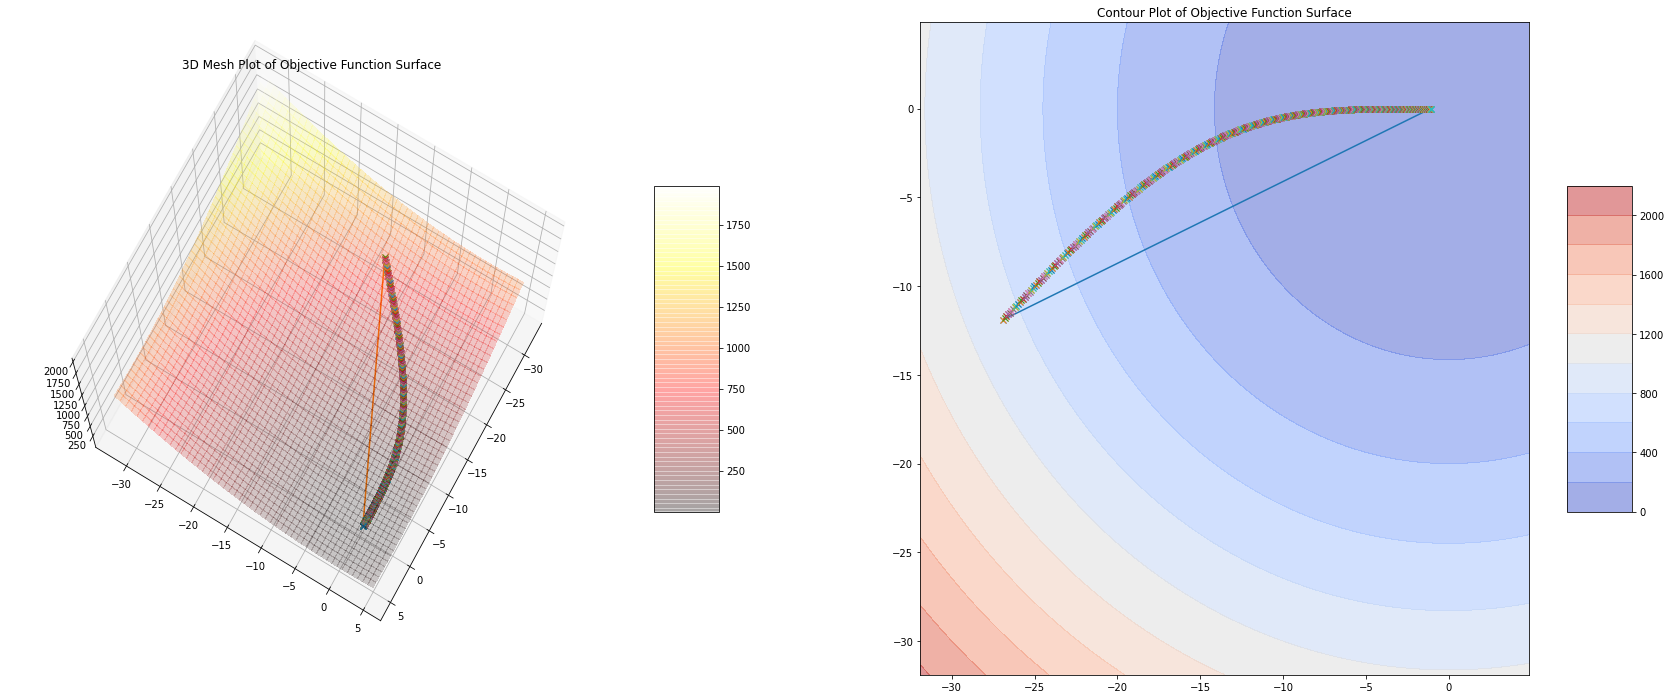

In [9]:
w1 = tf.Variable(float(random.randint(-50, 50)))
w2 = tf.Variable(float(random.randint(-50, 50)))


epochs = 500
optim = optimizers.Adam(0.1)

w1_path = [w1]
w2_path = [w2]

#run the epochs
for epoch in range(epochs):
  with tf.GradientTape() as g:
    g.watch([w1, w2])
    f = a1*((w1-b1)**2) + a2*((w2-b2)**2) + c
    df_dw = g.gradient(f, [w1, w2])
    optim.apply_gradients(zip(df_dw, [w1, w2]))
    w1_path.append(w1.numpy())
    w2_path.append(w2.numpy())

#plot the mesh and contour graphs with the steps
plot_mesh_and_contour(get_objective_value_convex, w1_path, w2_path)

#Optimizer Demonstration for Non-Convex Functions
*    SGD
*    RMS Prop
*    Nesterov Momentum
*    Adam

##Hyperparameters for the non-convex function

In [50]:
e = 0.01
k = 0.3
g = 0.5

##Plot the non-convex function surface

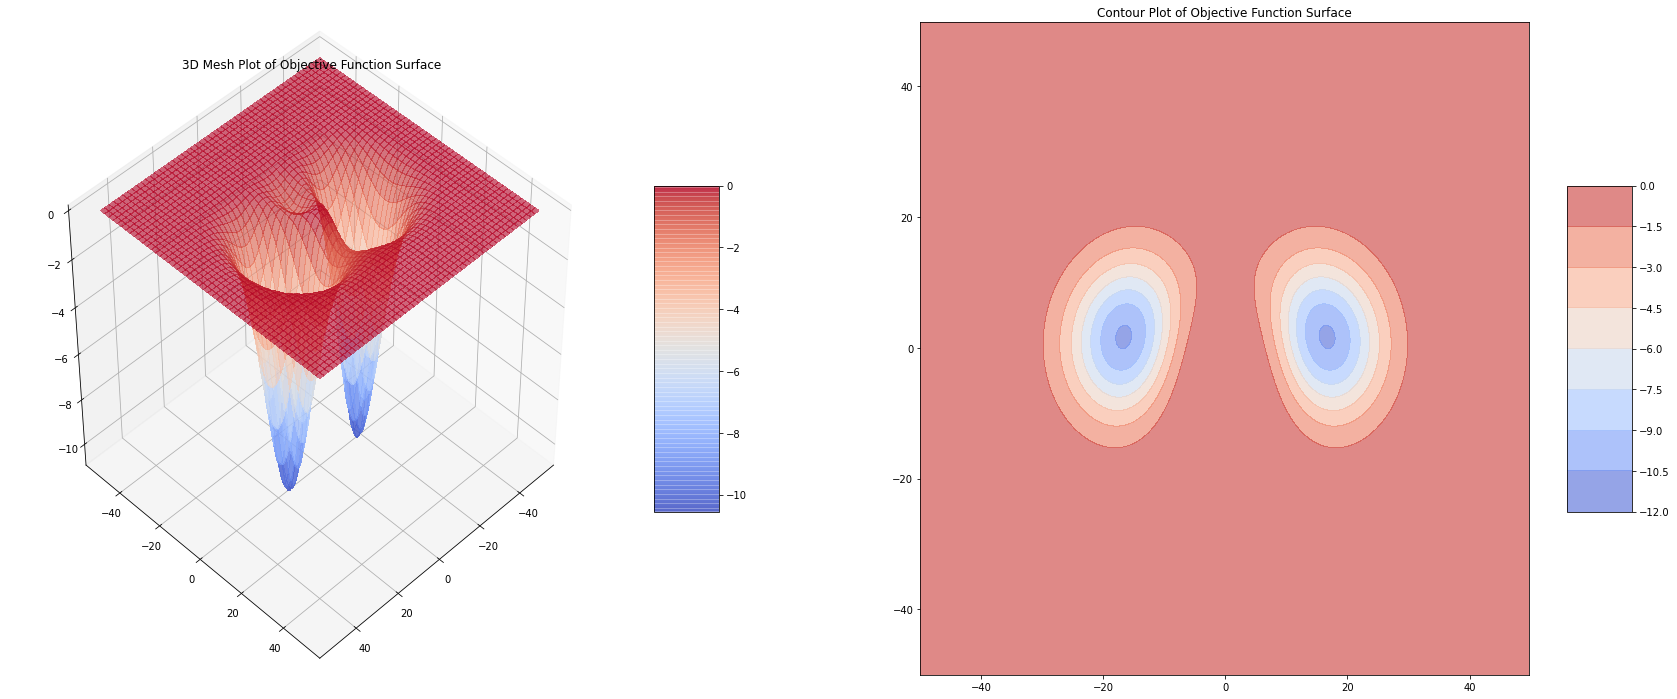

In [54]:
def get_objective_value_non_convex(w1_samples, w2_samples):
  return -0.01*(2**((-1)*(e)*(w1_samples**2 + w2_samples**2 )))*((k*(w1_samples**2) + w2_samples)**2 + ((w1_samples)**2 + g*(w2_samples**2))) 

fig = plt.figure(figsize=(30, 12))
ax = fig.add_subplot(1, 2, 1, projection='3d')
# ax = fig.gca(projection='3d')

# Make data
X = np.arange(-50, 50, 0.25)
Y = np.arange(-50, 50, 0.25)

X, Y = np.meshgrid(X, Y)

Z = get_objective_value_non_convex(X, Y)

# Plot the surface.
ax.view_init(45, 45)
surf = ax.plot_surface(X, Y, Z, cmap=cm.coolwarm,  linewidth=0, antialiased=False, alpha=0.6)
ax.set_title('3D Mesh Plot of Objective Function Surface')


# Add a color bar which maps values to colors.
fig.colorbar(surf, shrink=0.5, aspect=5)


ax = fig.add_subplot(1, 2, 2)
ax.set_title('Contour Plot of Objective Function Surface')
surf = ax.contourf(X, Y, Z, cmap=cm.coolwarm, alpha=0.6)
fig.colorbar(surf, shrink=0.5, aspect=5)


##SGD

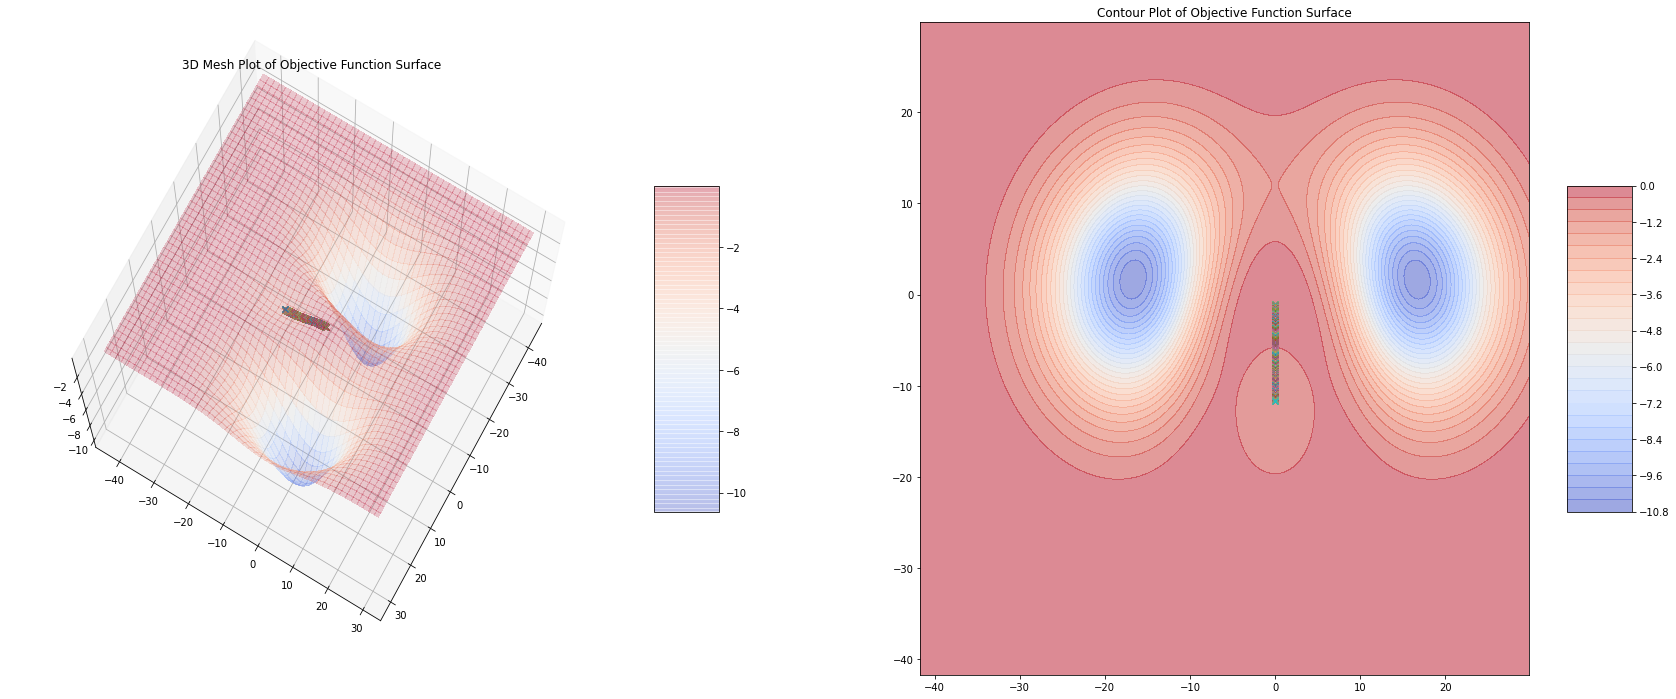

In [56]:
w1 = tf.Variable(float(random.randint(0, 0)))
w2 = tf.Variable(float(random.randint(-1, 1)))


epochs = 2000
optim = optimizers.SGD(1e-1)

w1_path = [w1]
w2_path = [w2]

#run the epochs
for epoch in range(epochs):
  with tf.GradientTape() as gt:
    gt.watch([w1, w2])
    f = -0.01*(2**((-1)*(e)*(w1**2 + w2**2 )))*((k*(w1**2) + w2)**2 + ((w1)**2 + g*(w2**2))) 
    df_dw = gt.gradient(f, [w1, w2])
    optim.apply_gradients(zip(df_dw, [w1, w2]))
    w1_path.append(w1.numpy())
    w2_path.append(w2.numpy())

#plot the mesh and contour graphs with the steps
plot_mesh_and_contour(get_objective_value_non_convex, w1_path, w2_path, extra_limit=30, levels=30)

##RMS Prop

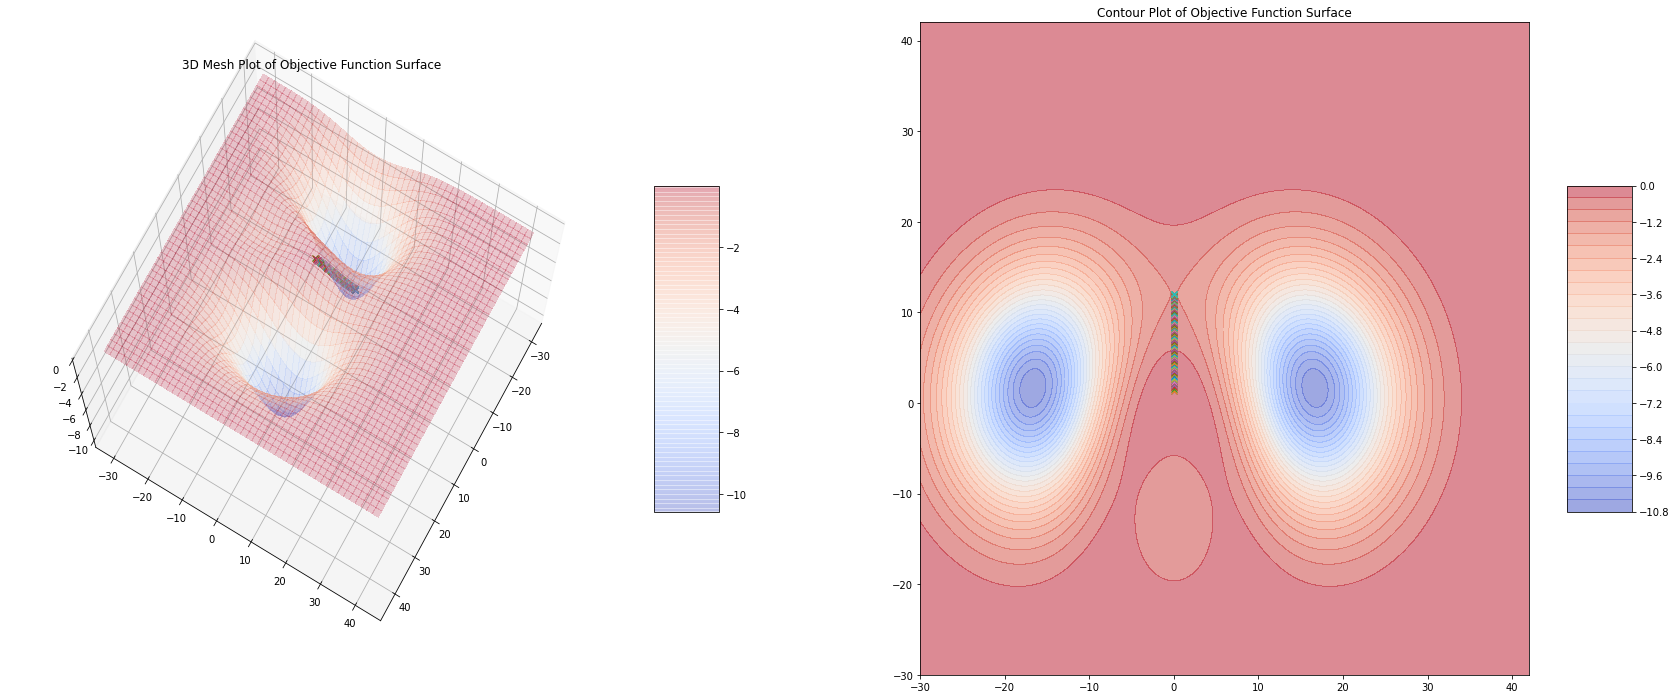

In [59]:
w1 = tf.Variable(float(random.randint(0, 0)))
w2 = tf.Variable(float(random.randint(-1, 1)))


epochs = 2000
optim = optimizers.RMSprop(1e-1)

w1_path = [w1]
w2_path = [w2]

#run the epochs
for epoch in range(epochs):
  with tf.GradientTape() as gt:
    gt.watch([w1, w2])
    f = -0.01*(2**((-1)*(e)*(w1**2 + w2**2 )))*((k*(w1**2) + w2)**2 + ((w1)**2 + g*(w2**2))) 
    df_dw = gt.gradient(f, [w1, w2])
    optim.apply_gradients(zip(df_dw, [w1, w2]))
    w1_path.append(w1.numpy())
    w2_path.append(w2.numpy())

#plot the mesh and contour graphs with the steps
plot_mesh_and_contour(get_objective_value_non_convex, w1_path, w2_path, extra_limit=30, levels=30)

##Nesterov Momentum

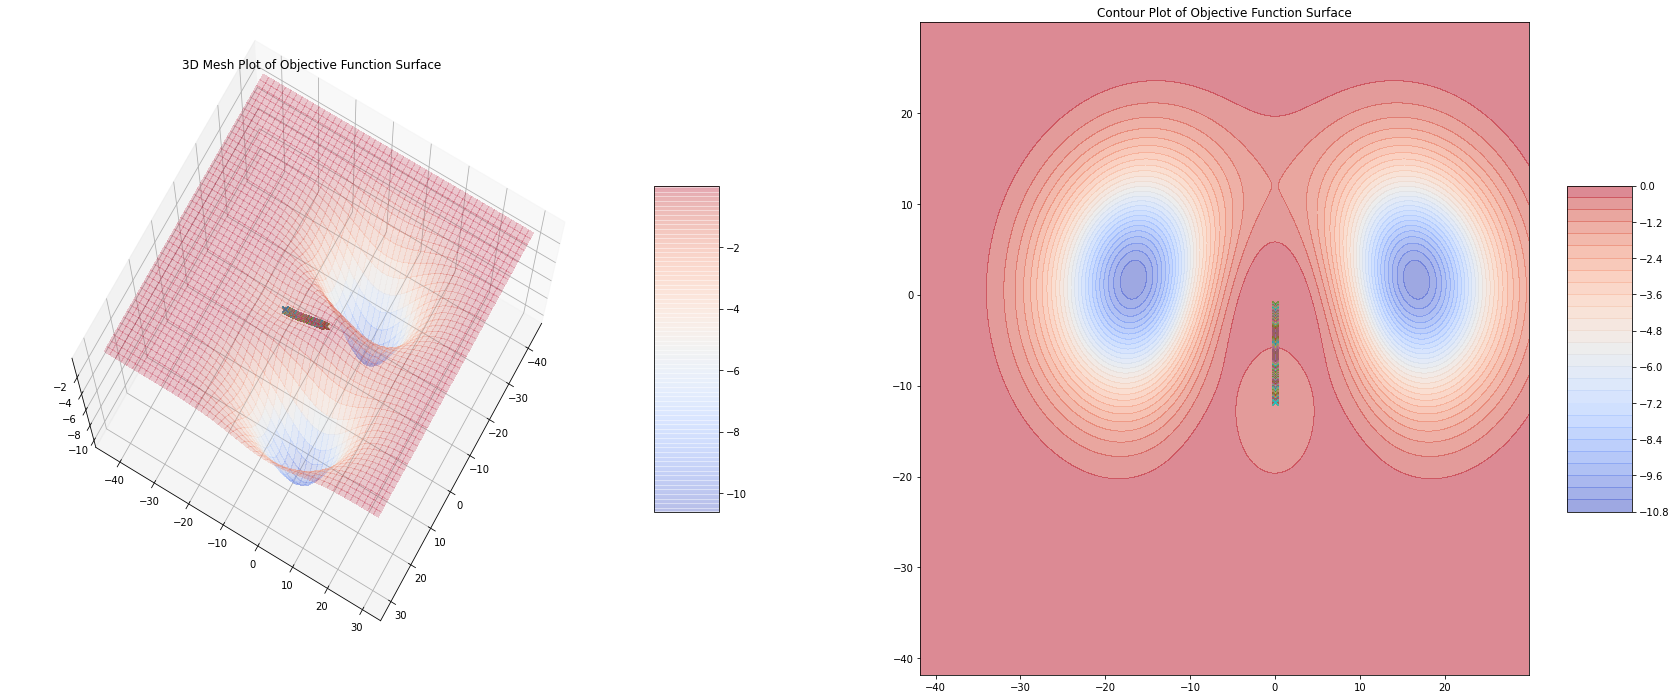

In [61]:
w1 = tf.Variable(float(random.randint(0, 0)))
w2 = tf.Variable(float(random.randint(-1, 1)))


epochs = 2000
optim = optimizers.SGD(1e-1, momentum=0.1,   nesterov=True)

w1_path = [w1]
w2_path = [w2]

#run the epochs
for epoch in range(epochs):
  with tf.GradientTape() as gt:
    gt.watch([w1, w2])
    f = -0.01*(2**((-1)*(e)*(w1**2 + w2**2 )))*((k*(w1**2) + w2)**2 + ((w1)**2 + g*(w2**2))) 
    df_dw = gt.gradient(f, [w1, w2])
    optim.apply_gradients(zip(df_dw, [w1, w2]))
    w1_path.append(w1.numpy())
    w2_path.append(w2.numpy())

#plot the mesh and contour graphs with the steps
plot_mesh_and_contour(get_objective_value_non_convex, w1_path, w2_path, extra_limit=30, levels=30)

##Adam 

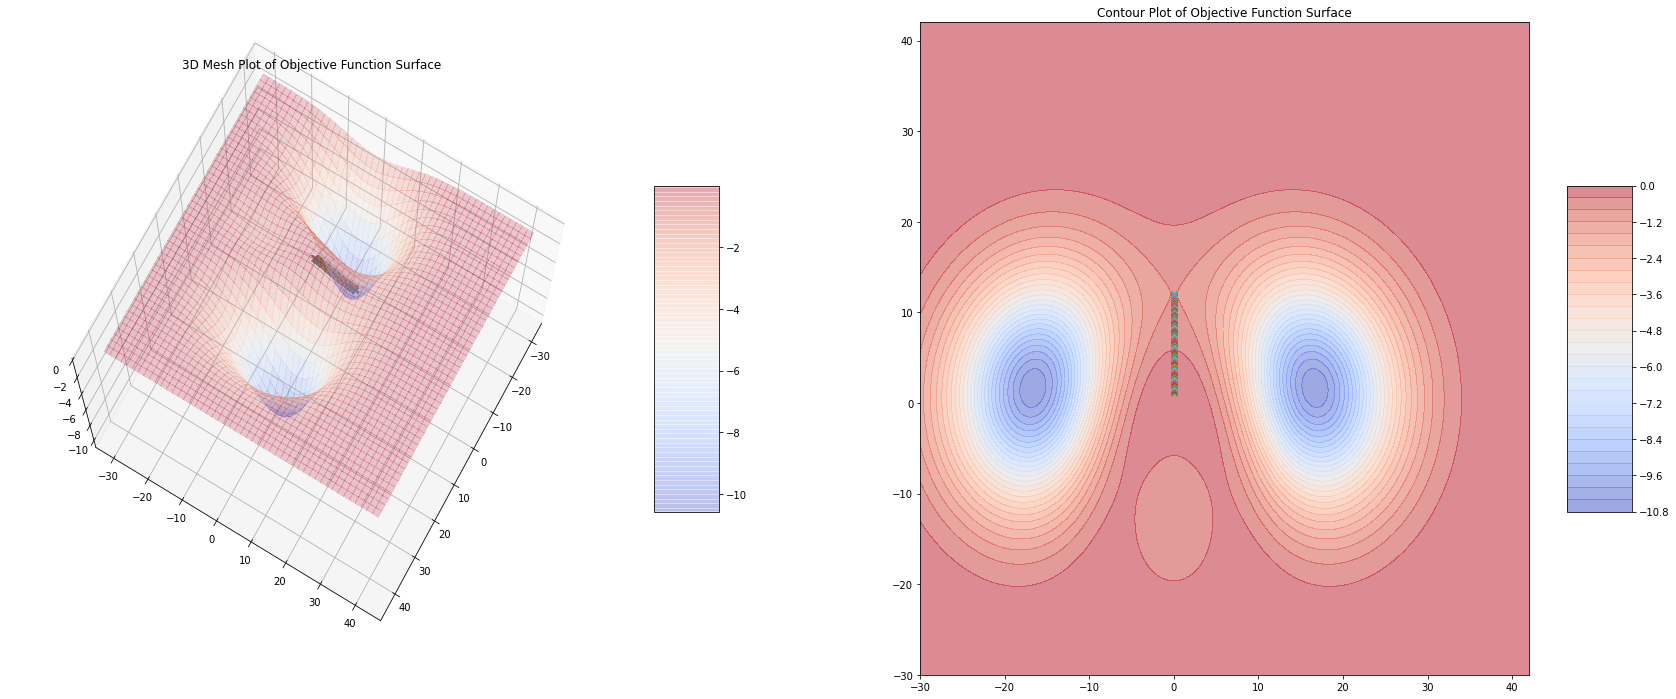

In [62]:
w1 = tf.Variable(float(random.randint(0, 0)))
w2 = tf.Variable(float(random.randint(-1, 1)))


epochs = 2000
optim = optimizers.Adam(1e-1)

w1_path = [w1]
w2_path = [w2]

#run the epochs
for epoch in range(epochs):
  with tf.GradientTape() as gt:
    gt.watch([w1, w2])
    f = -0.01*(2**((-1)*(e)*(w1**2 + w2**2 )))*((k*(w1**2) + w2)**2 + ((w1)**2 + g*(w2**2))) 
    df_dw = gt.gradient(f, [w1, w2])
    optim.apply_gradients(zip(df_dw, [w1, w2]))
    w1_path.append(w1.numpy())
    w2_path.append(w2.numpy())

#plot the mesh and contour graphs with the steps
plot_mesh_and_contour(get_objective_value_non_convex, w1_path, w2_path, extra_limit=30, levels=30)

# Convolutional Neural Networks (Total for this subsection : **30 points**)

---
In this section we will work with dog breeds classification. The dataset can be downloaded from Kaggle at (https://www.kaggle.com/samcrochet/p29crosspuredogs). There are 15 breeds of dogs in this dataset. Train, Validation and Test split as provided in the dataset can be used.

## To do

---
1. Download the pretrained model (VGG, ResNet, DenseNet, etc.) from the Keras or TorchVision library. {**1 point**}
2. Modify the final fully connected layer to accomodate 15 classes. {**1 point**}
3. Finetune the model to classify the given dataset of 15 dog breeds. {**10 points**}
4. Use the validation set to get the optimal hyperparameters so as to achieve high validation accuracy. In case you are adopting any other strategies like Data Augmentation to increase the accuracy, kindly mention the same in the jupyter notebook. {**5 points**}
5. Now use the test set to assess the generalization ability of the fine tuned model. Report the accuracy of the trained CNN on the test set. {**1 Point**}
6. You may refer to the Research Paper by Selvaraju et al.[5] for a technique to explain the working of a CNN by visualizing the region of the image that the CNN is looking at, in order to make the prediction.
7. Implement the Grad-CAM methodolgy by Selvaraju et al.[5] to visualize which regions of the test image is seminal to the classifier's output. {**10 points**}
8. In Selvaraju et al.[5], a methodology to verify the correctness of the explanations leveraging the ground truth bounding boxes has been proposed. In a dataset as we used in this lab, where such annotations are not available, Can you think of a way to verify the correctness of the explanation generated? (Implementation not needed. Just discuss the methodology you think is suitable to verify the correctness of the generated explanations.) {**2 points**}



---
**Reference:**

[5]. Ramprasaath R. Selvaraju, Michael Cogswell, Abhishek Das, Ramakrishna
Vedantam, Devi Parikh, Dhruv Batra; Grad-CAM: Visual Explanations From
Deep Networks via Gradient-Based Localization, The IEEE International
Conference on Computer Vision (ICCV), 2017, pp. 618-626.

##Paths

In [ ]:
# all CNN exercises to come here after
LAB_PATH = '/content/gdrive/My Drive/ANN/lab_1/'
DATASET_PATH  = LAB_PATH + 'dog_breeds_dataset/'

##Load the Dogs Dataset

In [ ]:
batch_size = 32
img_height = 224
img_width = 224


train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  DATASET_PATH + 'train',
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size, 
  label_mode='categorical'
)

valid_ds = tf.keras.preprocessing.image_dataset_from_directory(
  DATASET_PATH + 'val',
  seed=100,
  image_size=(img_height, img_width),
  batch_size=batch_size,
  label_mode='categorical'
)


test_ds = tf.keras.preprocessing.image_dataset_from_directory(
  DATASET_PATH + 'test',
  seed=200,
  image_size=(img_height, img_width),
  batch_size=batch_size,
  label_mode='categorical'
)

class_names = train_ds.class_names
num_classes = len(class_names)
print(class_names)

AUTOTUNE = tf.data.experimental.AUTOTUNE

data_augmentation = tf.keras.Sequential([
  tf.keras.layers.experimental.preprocessing.RandomFlip('horizontal'),
  tf.keras.layers.experimental.preprocessing.RandomRotation(0.2),
])


train_ds = train_ds.map(lambda x, y: (data_augmentation(x, training=True), y), num_parallel_calls=AUTOTUNE)

preprocess = tf.keras.applications.mobilenet_v2.preprocess_input

train_ds = train_ds.map(lambda x, y: (preprocess(x), y))
valid_ds = valid_ds.map(lambda x, y: (preprocess(x), y))
test_ds = test_ds.map(lambda x, y: (preprocess(x), y))



Found 1699 files belonging to 15 classes.
Found 483 files belonging to 15 classes.
Found 252 files belonging to 15 classes.
['beagle', 'gerbarian_shepsky', 'german_shepherd', 'golden_doodle', 'golden_retriever', 'great_dane', 'husky', 'labradoodle', 'labrador_retriever', 'maltese', 'maltipoo', 'poodle', 'pug', 'puggle', 'rottweiler']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


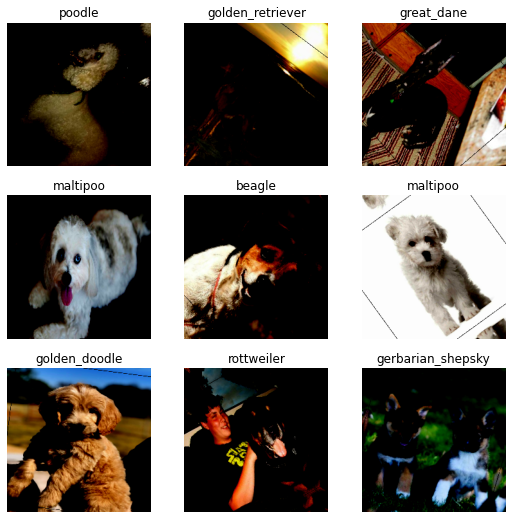

In [ ]:
#visualise the data
plt.figure(figsize=(9, 9))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy())
    plt.title(class_names[tf.argmax(labels[i], axis=0)])
    plt.axis("off")


##Data Augmentation and Rescale the Images

In [ ]:
def get_model():
  base_model = tf.keras.applications.MobileNetV2(
  include_top=False, weights='imagenet', input_tensor=None, input_shape=(img_height, img_width, 3),
    pooling=None, classes=num_classes, classifier_activation=None
  )
  base_model.trainable = True
  global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
  x = base_model.output
  x = global_average_layer(x)
  x = tf.keras.layers.Dropout(0.2)(x)

  lower_dense_layer = tf.keras.layers.Dense(512, kernel_regularizer='l2')
  lower_dense_activation_layer = tf.keras.layers.ReLU()

  x = lower_dense_layer(x)
  x = lower_dense_activation_layer(x)

  mid_dense_layer = tf.keras.layers.Dense(256, kernel_regularizer='l2')
  mid_dense_activation_layer = tf.keras.layers.ReLU()

  x = mid_dense_layer(x)
  x = mid_dense_activation_layer(x)

  upper_dense_layer = tf.keras.layers.Dense(128, kernel_regularizer='l2')
  upper_dense_activation_layer = tf.keras.layers.ReLU()

  x = upper_dense_layer(x)
  x = upper_dense_activation_layer(x)

  #num_classes is 15 in this case
  prediction_layer = tf.keras.layers.Dense(num_classes)
  output = prediction_layer(x)
  # output = softmax_layer(output_1)
  model = tf.keras.Model(base_model.input, output)
  model.build(input_shape=(img_height, img_width, 3))
  return model

In [ ]:
checkpoint_path = LAB_PATH + "training_3/cp.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

# Create a callback that saves the model's weights
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)

model = get_model()
base_learning_rate = 1e-04
model.trainable = True
# model.summary()
model.compile(optimizer=tf.keras.optimizers.Adam(lr=base_learning_rate),
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
# model.load_weights(checkpoint_path)
model.summary()
loss0, accuracy0 = model.evaluate(valid_ds)

Model: "functional_41"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_11 (InputLayer)           [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 225, 225, 3)  0           input_11[0][0]                   
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 32) 864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 112, 112, 32) 128         Conv1[0][0]                      
______________________________________________________________________________________

In [ ]:
initial_epochs = 25
history = model.fit(train_ds, epochs=initial_epochs, validation_data=valid_ds, callbacks=[cp_callback])

Epoch 1/25
53/54 [============================>.] - ETA: 0s - loss: 14.2063 - accuracy: 0.3667
Epoch 00001: saving model to /content/gdrive/My Drive/ANN/lab_1/training_3/cp.ckpt
54/54 [==============================] - 17s 315ms/step - loss: 14.2056 - accuracy: 0.3667 - val_loss: 12.7902 - val_accuracy: 0.6791
Epoch 2/25
53/54 [============================>.] - ETA: 0s - loss: 12.2160 - accuracy: 0.7258
Epoch 00002: saving model to /content/gdrive/My Drive/ANN/lab_1/training_3/cp.ckpt
54/54 [==============================] - 16s 295ms/step - loss: 12.2172 - accuracy: 0.7245 - val_loss: 11.5570 - val_accuracy: 0.7371
Epoch 3/25
53/54 [============================>.] - ETA: 0s - loss: 11.1565 - accuracy: 0.7983
Epoch 00003: saving model to /content/gdrive/My Drive/ANN/lab_1/training_3/cp.ckpt
54/54 [==============================] - 16s 296ms/step - loss: 11.1561 - accuracy: 0.7987 - val_loss: 10.8107 - val_accuracy: 0.7516
Epoch 4/25
53/54 [============================>.] - ETA: 0s - lo

In [ ]:
#test the model
loss_t, accuracy_t = model.evaluate(test_ds)

8/8 [==============================] - 0s 32ms/step - loss: 3.3626 - accuracy: 0.8056


Class Index 3
(7, 7, 1280)
(1280,)


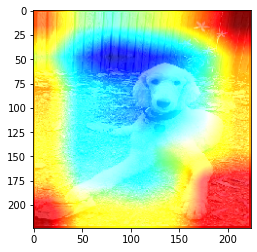

In [ ]:
IMAGE_PATH = DATASET_PATH + 'test/poodle/poodle.00017.jpg'

img = tf.keras.preprocessing.image.load_img(IMAGE_PATH, target_size=(224, 224))
img = tf.keras.preprocessing.image.img_to_array(img)

# print(img.shape)

# prediction = model.predict(img.reshape(1, 224, 224, 3))
# print(prediction)

grad_model = tf.keras.models.Model([model.inputs], [model.get_layer('Conv_1').output, model.output])

with tf.GradientTape() as tape:
    conv_outputs, predictions = grad_model(np.array([img]))
    print("Class Index {}".format(np.argmax(predictions)))
    loss = predictions[:, np.argmax(predictions)]

output = conv_outputs[0]
grads = tape.gradient(loss, conv_outputs)[0]

print(grads.shape)

gate_f = tf.cast(output > 0, 'float32')
gate_r = tf.cast(grads > 0, 'float32')
guided_grads = tf.cast(output > 0, 'float32') * tf.cast(grads > 0, 'float32') * grads

weights = tf.reduce_mean(guided_grads, axis=(0, 1))
print(weights.shape)

cam = np.ones(output.shape[0: 2], dtype = np.float32)

for i, w in enumerate(weights):
    cam += w * output[:, :, i]

cam = cv2.resize(cam.numpy(), (img_height, img_width))
cam = np.maximum(cam, 0)
heatmap = (cam - cam.min()) / (cam.max() - cam.min())

cam = cv2.applyColorMap(np.uint8(255*heatmap), cv2.COLORMAP_JET)

output_image = cv2.addWeighted(cv2.cvtColor(img.astype('uint8'), cv2.COLOR_RGB2BGR), 0.5, cam, 1, 0)

plt.imshow(output_image)